kaggle 地址：https://www.kaggle.com/c/house-prices-advanced-regression-techniques  

这是进阶版的。主要是为了比较几种模型框架。所以前面的特征工程部分内容，我也并没有做任何改动，重点都在后面的模型建造section

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x111dbbeb8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111f4a320>]], dtype=object)

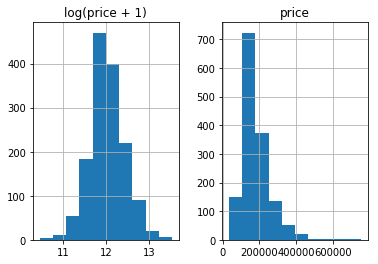

In [2]:
import numpy as np
import pandas as pd
train_df = pd.read_csv('./input/train.csv', index_col=0)
test_df = pd.read_csv('./input/test.csv', index_col=0)

%matplotlib inline
prices = pd.DataFrame({"price":train_df["SalePrice"], "log(price + 1)":np.log1p(train_df["SalePrice"])})
prices.hist()

In [3]:
y_train = np.log1p(train_df.pop('SalePrice'))
all_df = pd.concat((train_df, test_df), axis=0)

all_df['MSSubClass'].dtypes
all_df['MSSubClass'] = all_df['MSSubClass'].astype(str)

pd.get_dummies(all_df['MSSubClass'], prefix='MSSubClass').head()
all_dummy_df = pd.get_dummies(all_df)
all_dummy_df.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
2,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
3,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
4,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
5,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [4]:
all_dummy_df.isnull().sum().sort_values(ascending=False).head(10)

LotFrontage     486
GarageYrBlt     159
MasVnrArea       23
BsmtHalfBath      2
BsmtFullBath      2
BsmtFinSF2        1
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
GarageArea        1
dtype: int64

In [5]:
mean_cols = all_dummy_df.mean()
mean_cols.head(10)

LotFrontage        69.305795
LotArea         10168.114080
OverallQual         6.089072
OverallCond         5.564577
YearBuilt        1971.312778
YearRemodAdd     1984.264474
MasVnrArea        102.201312
BsmtFinSF1        441.423235
BsmtFinSF2         49.582248
BsmtUnfSF         560.772104
dtype: float64

In [6]:
all_dummy_df = all_dummy_df.fillna(mean_cols)
all_dummy_df.isnull().sum().sum()

0

In [7]:
numeric_cols = all_df.columns[all_df.dtypes != 'object']
numeric_col_means = all_dummy_df.loc[:, numeric_cols].mean()
numeric_col_std = all_dummy_df.loc[:, numeric_cols].std()
all_dummy_df.loc[:, numeric_cols] = (all_dummy_df.loc[:, numeric_cols] - numeric_col_means) / numeric_col_std

## 建立模型

In [8]:
dummy_train_df = all_dummy_df.loc[train_df.index]
dummy_test_df = all_dummy_df.loc[test_df.index]

X_train = dummy_train_df.values
X_test = dummy_test_df.values

### 做一点高级的Ensemble
一般来说，单个分类器的效果真的是很有限。我们会倾向于把N多的分类器合在一起，做一个“综合分类器”以达到最好的效果。

我们从刚刚的试验中得知，Ridge(alpha=15)给了我们最好的结果

In [9]:
from sklearn.linear_model import Ridge
ridge = Ridge(15)

### Bagging
Bagging把很多的小分类器放在一起，每个train随机的一部分数据，然后把它们的最终结果综合起来（多数投票制）。

Sklearn已经直接提供了这套构架，我们直接调用就行：

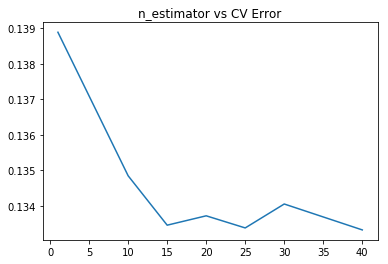

In [10]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_val_score

# 在这里，我们用CV结果来测试不同的分类器个数对最后结果的影响。

# 注意，我们在部署Bagging的时候，要把它的函数base_estimator里填上你的小分类器（ridge）

params = [1, 10, 15, 20, 25, 30, 40]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

可见，前一个版本中，ridge最优结果也就是0.135；而这里，我们使用25个小ridge分类器的bagging，达到了低于0.132的结果。

当然了，你如果并没有提前测试过ridge模型，你也可以用Bagging自带的DecisionTree模型：

代码是一样的，把base_estimator给删去即可

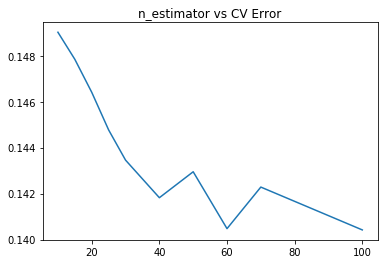

In [11]:
params = [10, 15, 20, 25, 30, 40, 50, 60, 70, 100]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

 从上图中，我们发现，单纯使用 DT 不太灵光，最好的结果也只是 0.140

### Boosting
Boosting比Bagging理论上更高级点，它也是揽来一把的分类器。  
但是把他们线性排列。下一个分类器把上一个分类器分类得不好的地方加上更高的权重，  
这样下一个分类器就能在这个部分学得更加“深刻”。

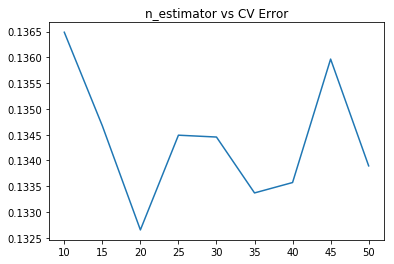

In [12]:
from sklearn.ensemble import AdaBoostRegressor

params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param, base_estimator=ridge)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

Adaboost+Ridge在这里，25个小分类器的情况下，也是达到了接近0.132的效果。

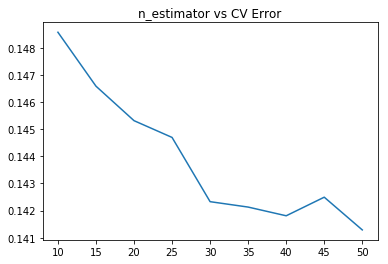

In [13]:
# 同理，这里，你也可以不必输入Base_estimator，使用Adaboost自带的DT。
params = [10, 15, 20, 25, 30, 35, 40, 45, 50]
test_scores = []
for param in params:
    clf = BaggingRegressor(n_estimators=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))

plt.plot(params, test_scores)
plt.title("n_estimator vs CV Error");

## XGBoost
它是一款Boosting框架的模型，但是其中做了很多的改进，经常应用在kaggle的竞赛中

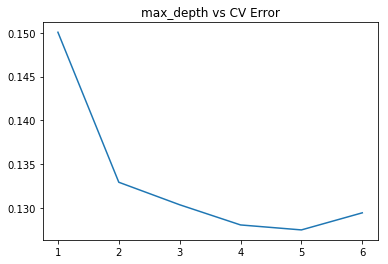

In [14]:
from xgboost import XGBRegressor
params = [1,2,3,4,5,6]
test_scores = []
for param in params:
    clf = XGBRegressor(max_depth=param)
    test_score = np.sqrt(-cross_val_score(clf, X_train, y_train, cv=10, scoring='neg_mean_squared_error'))
    test_scores.append(np.mean(test_score))
    
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("max_depth vs CV Error");